# Predicting with Exponential Moving Averages

I've had some success predicting swings by eyeballing exponential moving averages (EMAs). Now I want to use that idea to backtest against months of OHLC data.

In [1]:
# Standard library modules
import os
import sys
import math
import time
import json
import random
import numbers
import datetime

# Extra installed modules
import web3
import tqdm
import numpy  as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import mplfinance as mpf
import scipy
import scipy.stats
%matplotlib widget

# My own functions for analysis of BSC data
import bsc_analysis

In [2]:
# For when I change the bsc_analysis module
import importlib
importlib.reload(bsc_analysis)

<module 'bsc_analysis' from '/home/jovyan/repos/bsc-learning/bsc_analysis.py'>

## OHLC Data

The bsc_analysis module includes an OHLCData class that obtains OHLC data from whatever source, can save/load as JSON, and can update on demand. There's also an OHLCStats class that calculates EMAs and crossing points. Both are thin wrappers around DataFrames.

In [3]:
ohlc = bsc_analysis.OHLCData(start_date='2021-07-01')
stats = bsc_analysis.OHLCStats(ohlc.data)

Loaded 244 days of OHLC from storage file
Retrieving data:


OHLC data [2022-03-01] pulled=   0 saved=   0 : 100%|██████████| 244/244 [00:01<00:00, 148.32it/s]


Saved 244 days of OHLC to storage file


## Plotting OHLC and EMAs

            ema_high_10  ema_low_10  ema_high_20  ema_low_20  ema_high_60  \
2021-07-01   302.892545  288.731772   302.892545  288.731772   302.892545   
2021-07-02   294.311099  287.353152   294.701165  287.415817   294.961209   
2021-07-03   295.989589  287.365136   296.091123  287.403753   296.175695   
2021-07-04   299.549546  290.537792   299.181216  290.172637   298.964757   
2021-07-05   301.628689  293.850644   301.022226  293.052420   300.636302   
...                 ...         ...          ...         ...          ...   
2022-02-25   386.214992  373.898160   396.846155  384.304768   434.405952   
2022-02-26   384.004087  373.816350   394.675570  383.270810   432.426591   
2022-02-27   381.855603  371.285412   392.533842  381.044656   430.450917   
2022-02-28   384.077885  369.542965   392.680919  379.202494   429.258005   
2022-03-01   388.659566  374.003699   394.261511  380.619114   428.602702   

            ema_low_60  ema_high_120  ema_low_120  
2021-07-01  288.731772 

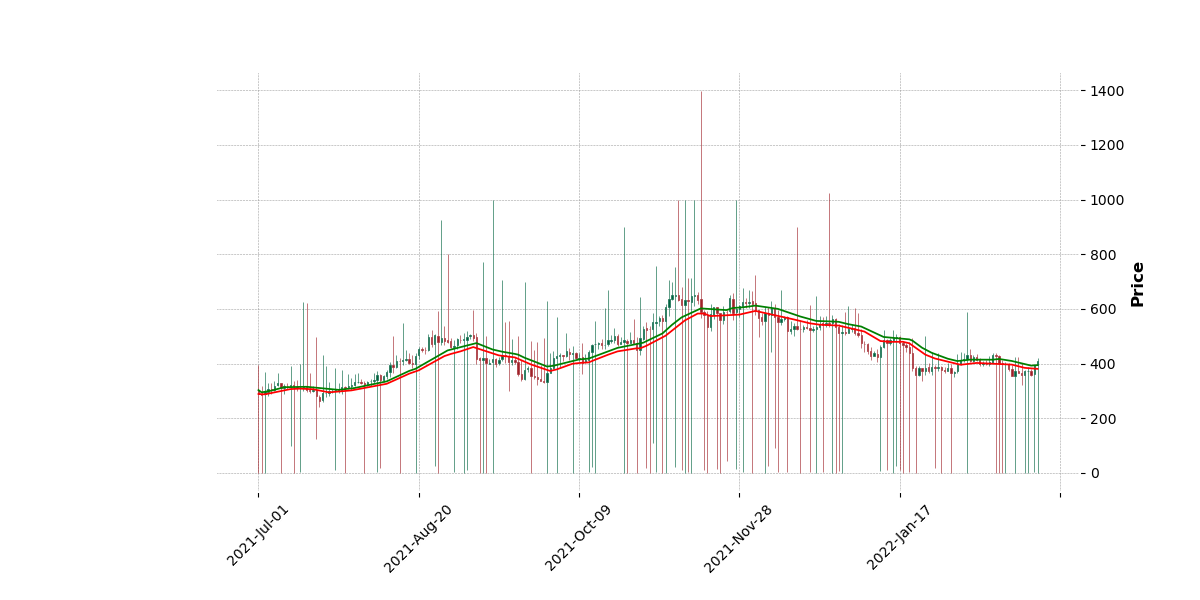

In [4]:
agg_dict = {'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'trades': 'sum'}
days = ohlc.data.resample('D').agg(agg_dict)
stats_days = bsc_analysis.OHLCStats(days)
print(stats_days.emas)
print(stats.emas['ema_high_10'].shape)
#fig = mpf.figure(figsize=(8, 6), dpi=80)
panels = [
    mpf.make_addplot(stats_days.emas['ema_high_20'], type='line', color='g', panel=0),
    mpf.make_addplot(stats_days.emas['ema_low_20' ], type='line', color='r', panel=0),
]
mpf.plot(days, type='candle', figsize=(12,6), style='charles', addplot=panels)


## PancakeSwap Prediction Data

Implement a class that obtains data about past Prediction games on PancakeSwap, can save/load as JSON, and can update on demand.


## Auto Trading

Okay, that kind of prediction is a bust, for now. Back to some more realistic goals:

* [DONE] First, revisit the OHLC to incorporate the stats into the same object
* Next, a function that takes an input slice of OHLC+stats, and a list of conditions, and tells you whether the conditions have been met.
* Then a limit-trading bot that stores a list of conditional transactions and monitors those conditions. When the specified conditions are met, it executes the transaction, making up to a certain number of tries but continuing to monitor those conditions and aborting if they go out of range. It should pay extra for the gas (always, or if the transaction is above a certain threshold?). It should keep a list of completed transactions, too, and offer some interface to allow the list to change.
* When I'm done with that bot, make a function that consults an ML model to decide whether or not to trade, and an evaluation function that backtests a given model over the last several months. Build such a model and train it.


# Predicting with Expectation Maximization

Ok so here's a twist to the EMA saga. I feel that now I can track how long ago each EMA crossed over with another EMA or with the High/Low price, these numbers should be able to tell me whether I'm in a period of growth, or about to start one or coming to the end of one. Before I try this on live data, I need to have some confidence that I can find that kind of feature in synthetic data first. So here's the plan for that:

Start with a token price that is executing a random walk, and a model that parameterizes the overall trend of the token's random walk: upward, downward, or steady. Then generate synthetic OHLC data using the model, and run our EMA+crossings indicators on the result. Look at the distributions of the indicators and see if they're easily separable. Use simple probability theory to calculate - for each time slice - the probability that each time slice comes from each model. Plot the results to see if we really do have separable populations. If not, do some feature engineering to turn them into easily separable populations. Now we have our synthetic data ready to go.

Now we use an expectation maximization algorithm to see if, starting from no knowledge of the model, we can derive a similar model from the data. Plot those probabilities at the end of the algorithm to see how well we did.

Once that is working - and not before - I can try the same thing on live data.

In [5]:
# This model is very simple so far
em_model = {
    'moon' : {
        'steps_μ'     : 0.05,
        'steps_σ'     : 1,
        'trade_λ'     : 50,
        'high_open_α' : 2,
        'high_open_σ' : 1,
        'open_low_α'  : 1,
        'open_low_σ'  : 1,
    },
    
    'stable': {
        'steps_μ'     : 0.0,
        'steps_σ'     : 0.8,
        'trade_λ'     : 5,
        'high_open_α' : 1,
        'high_open_σ' : 1,
        'open_low_α'  : 1,
        'open_low_σ'  : 1,
    },
    
    'crash' : {
        'steps_μ'     : -.02,
        'steps_σ'     : 0.1,
        'trade_λ'     : 20,
        'high_open_α' : 1,
        'high_open_σ' : 1,
        'open_low_α'  : 2,
        'open_low_σ'  : 1,
    }
}

### Functions to Generate Random Walk OHLC Data

In [6]:
def get_random_ohlc(start_date, start_value, n_periods, parameters):
    rng       = np.random.default_rng()
    if isinstance(start_date, datetime.datetime):
        then  = start_date
    else:
        then  = datetime.datetime.fromisoformat(start_date)
    minute    = datetime.timedelta(minutes=1)
    current   = start_value
    ohlc_list = []
    n_trades  = rng.poisson(
        lam    = parameters['trade_λ'],
        size   = n_periods
    )
    ohlc_frame = pd.DataFrame(columns=['open', 'high', 'low', 'close', 'trades'], )
    for period in range(n_periods):
        oo = hh = ll = current
        for step_idx in range(n_trades[period]):
            current_log10 = math.log(current, 10)
            limiter = 10 ** int(current_log10 / 3)
            step = rng.normal(loc = parameters['steps_μ'], scale  = limiter * parameters['steps_σ'])
            
            # Reduce the step until the result is greater than zero
            positive = False
            while not positive:
                try:
                    next_log10 = math.log(current + step, 10)
                    positive   = True
                except:
                    step /= 2
            
            # Keep reducing the step until there's at most one order of magnitude change
            while int(next_log10) + 1 < int(current_log10):
                step /= 2.
                next_log10 = math.log(current + step, 10)
            # ...in either direction
            while int(next_log10) > 1 + int(current_log10):
                step /= 2.
                next_log10 = math.log(current + step, 10)
            current += step
            hh = max(hh, current)
            ll = min(ll, current)
        ohlc_frame.loc[then] = (oo, hh, ll, current, n_trades[period])
        then += minute
    return ohlc_frame

def get_random_ohlc_epochs(start_date, start_value, epochs, hyperparameters):
    frames    = []
    then      = datetime.datetime.fromisoformat(start_date)
    current   = start_value
    minute    = datetime.timedelta(minutes=1)
    for (key, n_periods) in epochs:
        frame      = get_random_ohlc(then, current, n_periods, hyperparameters[key])
        frame[key] = True
        then      += n_periods * minute
        current    = frame.loc[then - minute]['close']
        frames.append(frame)
    return pd.concat(frames)

### Plotting Random Walk OHLC Data from Each Single Model

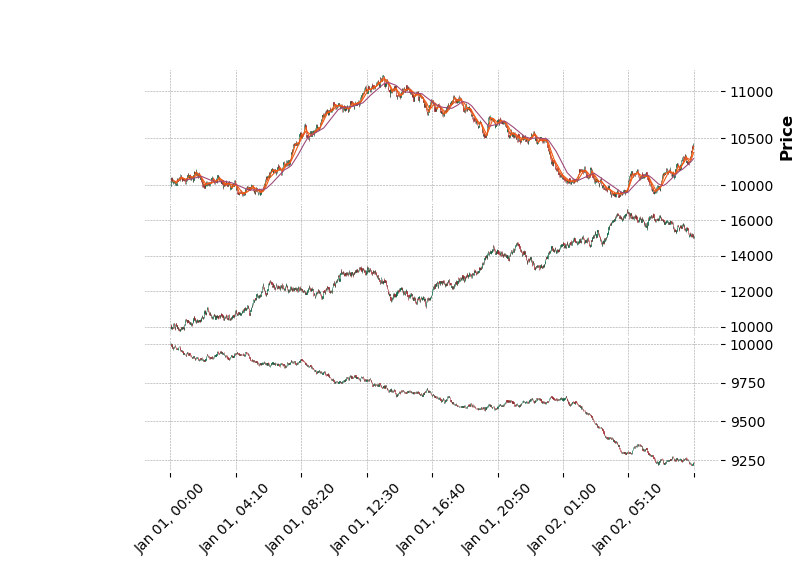

In [7]:
# Let's grab some data and plot it
em_ohlc = {key: get_random_ohlc('2020-01-01', 10000, 2000, em_model[key]) for key in em_model}
panels = [
    mpf.make_addplot(em_ohlc['moon' ], type='candle', panel=1),
    mpf.make_addplot(em_ohlc['crash'], type='candle', panel=2),
]

mpf.plot(em_ohlc['stable'], type='candle', style='charles', mav=[10,20,60], warn_too_much_data=100000, addplot=panels, panel_ratios=(1,1,1))

In [8]:
try:
    import powerlaw
except:
    !pip install powerlaw
    import powerlaw


for key in []:#('moon',):# 'stable', 'crash'):
    dist_ho = (em_ohlc[key]['high'] - em_ohlc[key]['open'])
    dist_ol = (em_ohlc[key]['open'] - em_ohlc[key]['low' ])
    #figure = plt.figure()
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    #dist_ho.plot.hist(color='g', alpha=0.5)
    fit = powerlaw.Fit(dist_ho.to_numpy(),xmin=0,discrete=False)
    #fit.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
    #fit.plot_pdf( color= 'k')
    print('alpha= ',fit.power_law.alpha,'  sigma= ',fit.power_law.sigma)
    #rv = scipy.stats.powerlaw(fit.power_law.alpha)
    r = 0.5-scipy.stats.powerlaw.rvs(fit.power_law.alpha, loc=0, scale=fit.power_law.sigma, size=10000)
    print(r)
    plt.xlim(0,10)
    plt.hist(r, density=True, histtype='stepfilled', color='r', alpha=0.2)

[0.9673537  0.96588671 0.84299565 ... 0.89876717 0.90388383 0.80062826]


Calculating best minimal value for power law fit
/opt/conda/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


alpha=  2743.3642883854995   sigma=  287.47789002822134


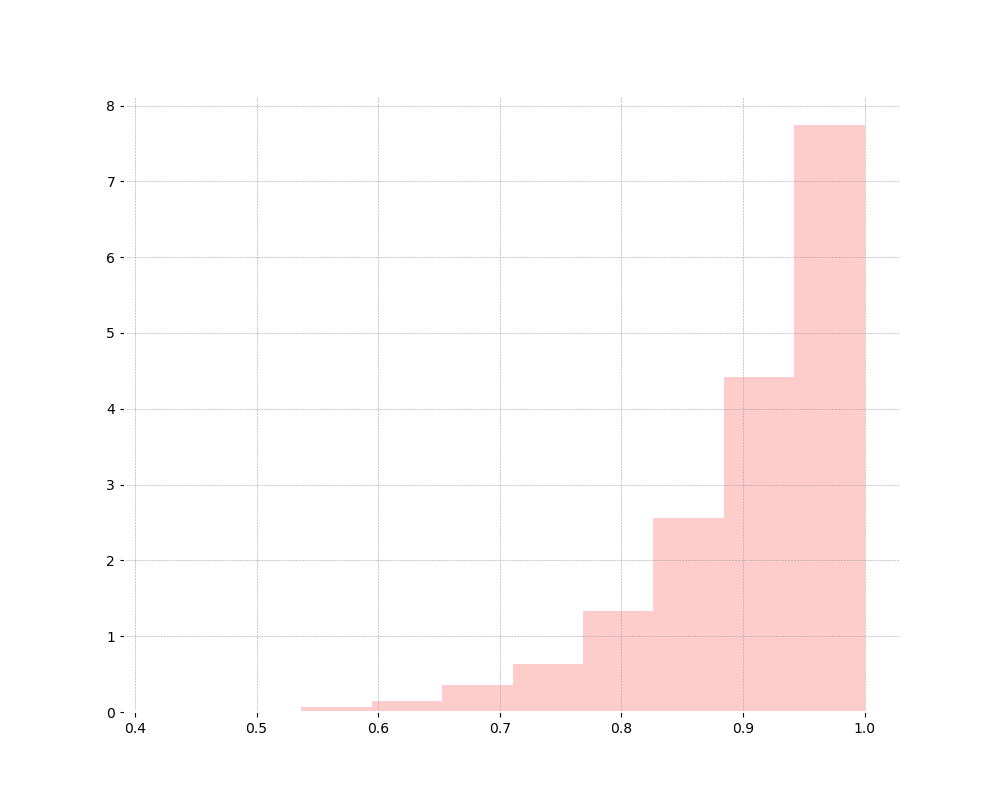

In [9]:
fig = plt.figure(figsize=(10, 8))
fig.clear()
#r = fit.power_law.sigma-scipy.stats.powerlaw.rvs(fit.power_law.alpha, loc=0, scale=fit.power_law.sigma, size=10000)
#print(r)
#plt.xlim(-5,5)
#plt.hist(r, density=True, histtype='stepfilled', color='r', alpha=0.2)
import scipy.stats
pow_rvs = scipy.stats.powerlaw.rvs(10, loc=0, scale=1, size=10000)
print(pow_rvs)
pow_fit = powerlaw.Fit(pow_rvs, xmin=0, discrete=False)
print('alpha= ',pow_fit.power_law.alpha,'  sigma= ',pow_fit.power_law.sigma)

plt.hist(pow_rvs, density=True, histtype='stepfilled', color='r', alpha=0.2)
plt.show()

### Using EM to Learn a Single Model in OHLC Data

Need to figure out a way to have multiple factors so that we have P(

In [10]:
def simple_random_model(n_cats, min, max):
    rng    = np.random.default_rng()
    return {
        ii: {
            # Characterize the distributions in play
            'steps_μ'     : 0.05,
            'steps_σ'     : 1,
            'trade_λ'     : rng.integers(10,50),
            'high_open_α' : rng.integers(1,10),
            'high_open_σ' : rng.integers(1,10),
            'open_low_α'  : rng.integers(1,10),
            'open_low_σ'  : rng.integers(1,10),
        }
        for ii in range(n_cats)
    }

def simple_print_model(model, label):
    print(f'Model: {label}')
    for cat in model:
        print(f'Category {cat:10}' +
              f' : steps     (μ={model[cat]["steps_μ"    ]:8.5f}, σ={model[cat]["steps_σ"    ]:8.5f})' +
              f' : trades    (λ={model[cat]["trade_λ"    ]:8.5f})' +
              f' : high-open (α={model[cat]["high_open_α"]:8.5f}, σ={model[cat]["high_open_σ"]:8.5f})' +
              f' : open-low  (α={model[cat]["open_low_α" ]:8.5f}, σ={model[cat]["open_low_σ" ]:8.5f})'
             )
    return

def P_events_from_model(frame, params):
    # Calculate additional features we need in the next step
    high_open = frame['high'] - frame['open']
    open_low  = frame['open'] - frame['low' ]
    
    # Calculate one column for each feature in use
    frames = [
            frame['trades'].apply(lambda rv: scipy.stats.poisson.pmf(rv, params['trade_λ'])),
            high_open.apply(      lambda rv: scipy.stats.powerlaw.pdf(rv, a=params['high_open_α'], scale=params['high_open_σ'])),
            open_low.apply(       lambda rv: scipy.stats.powerlaw.pdf(rv, a=params['open_low_α' ], scale=params['open_low_σ' ])),
    ]
    together = pd.concat(frames, axis=1)
    
    # Return the product
    return together.product()

def simple_estimate_weights(frame, start_date, n_periods, loglike, model):
    weights = np.empty((0,len(model)))
    then    = datetime.datetime.fromisoformat(start_date)
    minute  = datetime.timedelta(minutes=1)
    weights = pd.DataFrame(index=frame.index)
    for cat in model:
        weights[f'P(from {cat})'] = P_events_from_model(frame, model[cat])
    
    weight_cols = [f'P(from {cat})' for cat in model]
    
    # Normalize those probabilities
    weight_sums = weights[weight_cols].sum(axis=1)
    for col in weight_cols:
        weights[col] /= weight_sums
    #loglike += math.log(weight_sums.sum())
    return loglike, weights

In [11]:
simple_print_model(em_model, 'Simple')
loglike, weights = simple_estimate_weights(em_ohlc['crash'], '2020-01-01', 2000, 0., em_model)
print(weights)

Model: Simple
Category moon       : steps     (μ= 0.05000, σ= 1.00000) : trades    (λ=50.00000) : high-open (α= 2.00000, σ= 1.00000) : open-low  (α= 1.00000, σ= 1.00000)
Category stable     : steps     (μ= 0.00000, σ= 0.80000) : trades    (λ= 5.00000) : high-open (α= 1.00000, σ= 1.00000) : open-low  (α= 1.00000, σ= 1.00000)
Category crash      : steps     (μ=-0.02000, σ= 0.10000) : trades    (λ=20.00000) : high-open (α= 1.00000, σ= 1.00000) : open-low  (α= 2.00000, σ= 1.00000)
                     P(from moon)  P(from stable)  P(from crash)
2020-01-01 00:00:00           NaN             NaN            NaN
2020-01-01 00:01:00           NaN             NaN            NaN
2020-01-01 00:02:00           NaN             NaN            NaN
2020-01-01 00:03:00           NaN             NaN            NaN
2020-01-01 00:04:00           NaN             NaN            NaN
...                           ...             ...            ...
2020-01-02 09:15:00           NaN             NaN            Na

ValueError: zero-size array to reduction operation maximum which has no identity

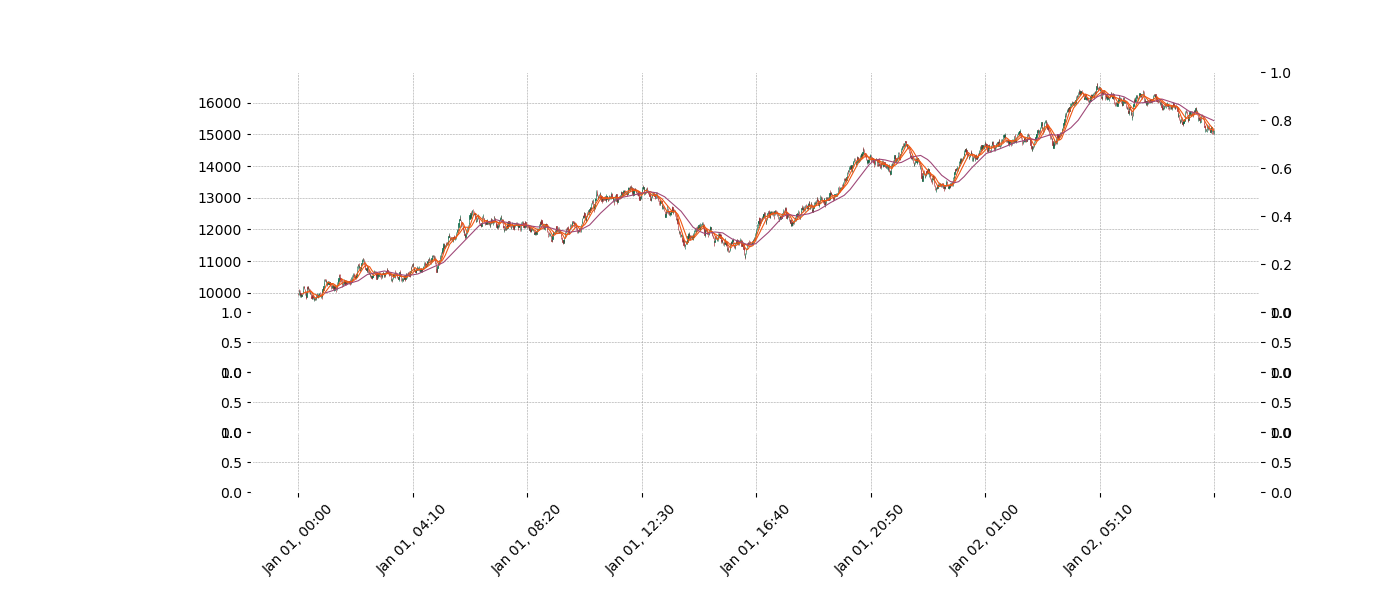

In [12]:
panels = [
    mpf.make_addplot(weights['P(from moon)'  ], type='scatter', color='g', markersize=1, panel=1),
    mpf.make_addplot(weights['P(from stable)'], type='scatter', color='k', markersize=1, panel=2),
    mpf.make_addplot(weights['P(from crash)' ], type='scatter', color='r', markersize=1, panel=3),
]
mpf.plot(em_ohlc['moon'], type='candle', style='charles', figsize=(14,6), mav=[10,20,60], warn_too_much_data=100000, addplot=panels, panel_ratios=(4,1,1,1))

In [13]:
def simple_maximize_likelihood(data, weights, model, min_prob= 0.1):
    new_model = []
    for ii in range(len(model)):
        col    = weights[:,ii]
        sumcol = sum(col)
        mu     = sum(col * data) / sumcol
        sigma  = sqrt(sum(col * (data - mu) ** 2) / sumcol)
        weight = sumcol / len(data)
        if weight >= min_prob:
            new_model.append({
                'weight' : weight,
                'μ'      : mu,
                'σ'      : sigma,
            })
    return new_model                         

def simple_em_iteration(events, model, min_prob= 0.05):
    # Step 1: For each point, and each source calculate the P(this point came from this source)
    loglike, weights = simple_estimate_weights(events, 0., model)
    # Step 2: Calculate Bayesian posterior P(source | data) for each data point and source
    # Step 3: Reestimate model parameters for each source , using the calculated probabilites to weight each value
    model = simple_maximize_likelihood(events, weights, model, min_prob)
    return model, loglike

def simple_iterate_over_models(events_dict, n_cats= 3, min_prob= 0.05, start= 0, end= 10, n_iters= 12):
    new_models = {}
    for key in models:
        print('='*80)
        # Step 0: Assign some kind of model with random parameters and multiple sources generating data, and equal priors
        model = simple_flat_model(n_cats, start, end)
        simple_print_model(model, f'{key} start')
        
        for ii in range(n_iters):
            model, loglike = simple_em_iteration(events_dict[key], model, min_prob)
            new_models[key] = model
            if ii == 0:
                print('-'*80)
                simple_print_model(model,   f'{key} iteration {ii:3} : log(likelihood) = {loglike}')
        print('-'*80)
        simple_print_model(model,       f'{key} output model  : log(likelihood) = {loglike}')
    return new_models

### Plotting Random Walk OHLC Data from Multiple Models

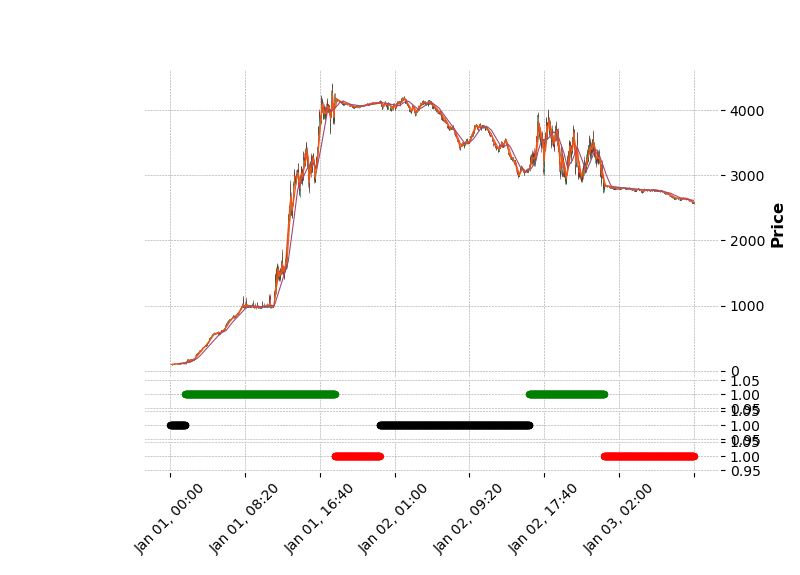

In [14]:
# Let's grab multiple epochs of data and plot it
epochs = [
    ('stable',  100),
    ('moon',   1000),
    ('crash',   300),
    ('stable', 1000),
    ('moon',    500),
    ('crash',   600),
]
em_ohlc_epochs = get_random_ohlc_epochs('2020-01-01', 100, epochs, em_model)
#mpf.plot(em_ohlc_epochs, type='candle', style='charles', mav=[10,20,60])
#mpf.make_addplot(em_ohlc_epochs.index[em_ohlc_epochs['moon'] == True])
panels = [
    mpf.make_addplot(em_ohlc_epochs['moon'  ], type='scatter', color='g', panel=1),
    mpf.make_addplot(em_ohlc_epochs['stable'], type='scatter', color='k', panel=2),
    mpf.make_addplot(em_ohlc_epochs['crash' ], type='scatter', color='r', panel=3),
]
mpf.plot(em_ohlc_epochs, type='candle', style='charles', mav=[10,20,60], warn_too_much_data=100000, addplot=panels, panel_ratios=(10,1,1,1))

### Using EM to Learn Multiple Models in OHLC Data

In [16]:
em_ohlc_epochs.index[em_ohlc_epochs['crash'] == True]

DatetimeIndex(['2020-01-01 18:20:00', '2020-01-01 18:21:00',
               '2020-01-01 18:22:00', '2020-01-01 18:23:00',
               '2020-01-01 18:24:00', '2020-01-01 18:25:00',
               '2020-01-01 18:26:00', '2020-01-01 18:27:00',
               '2020-01-01 18:28:00', '2020-01-01 18:29:00',
               ...
               '2020-01-03 10:10:00', '2020-01-03 10:11:00',
               '2020-01-03 10:12:00', '2020-01-03 10:13:00',
               '2020-01-03 10:14:00', '2020-01-03 10:15:00',
               '2020-01-03 10:16:00', '2020-01-03 10:17:00',
               '2020-01-03 10:18:00', '2020-01-03 10:19:00'],
              dtype='datetime64[ns]', length=900, freq=None)

### Let's Try This Against Real-World OHLC Data

I selected BabyDogeCoin as it has lots of activity and different periods of mooning and crashing.

In [17]:
addr_wbnb = '0xbb4CdB9CBd36B01bD1cBaEBF2De08d9173bc095c'
addr_bdc  = '0xc748673057861a797275cd8a068abb95a902e8de'
bdc_ohlc  = bsc_analysis.OHLCData(token_address= addr_bdc, quote_address= addr_wbnb, start_date='2021-06-01')

Loaded 554 days of OHLC from storage file
Retrieving data:


OHLC data [2022-03-01] pulled=   0 saved=   0 : 100%|██████████| 274/274 [00:02<00:00, 106.41it/s]


Saved 554 days of OHLC to storage file


#### Characterizing Marked Data

Highlight some periods in BabyDoge's history when we know it was behaving a certain way, and then look a the distributions of each of the features/indicators we have.

In [18]:
def get_marked_ohlc_stats(ohlc, interval):
    start, end = interval
    return bsc_analysis.OHLCStats(ohlc[start:end])

def characterize_ohlc(stats):
    ohlc = stats.data
    high_open = ohlc['high'] - ohlc['open']
    high_open_norm = high_open / stats.emas['ema_low_60']
    print(high_open_norm)
    high_open_norm.plot.hist(bins=500, alpha=0.5)
    plt.xlim(0, 10)
    return

In [19]:
marked_periods = {
    'moon' : [
        ('2022-01-01', '2022-01-19'),
        ('2021-10-25', '2021-10-31'),
        ('2021-06-08', '2021-07-04'),
    ],
    'stable' : [
        ('2021-09-01', '2021-10-10'),
    ],
    'crash' : [
        ('2022-01-25', '2022-02-24'),
        ('2021-11-02', '2021-12-15'),
    ],
}

marked_ohlc = {
    key: [
        get_marked_ohlc_stats(bdc_ohlc, period)
        for period in marked_periods[key]
    ]
    for key in marked_periods
}

2022-01-25 00:00:00    2.706373e-05
2022-01-25 00:01:00    1.903462e-06
2022-01-25 00:02:00    9.376506e-06
2022-01-25 00:03:00    6.802825e-06
2022-01-25 00:04:00    0.000000e+00
                           ...     
2022-02-24 23:54:00    5.004664e-03
2022-02-24 23:55:00    7.930515e-07
2022-02-24 23:56:00    5.006605e-03
2022-02-24 23:58:00    5.430723e-06
2022-02-24 23:59:00    0.000000e+00
Length: 41745, dtype: float64


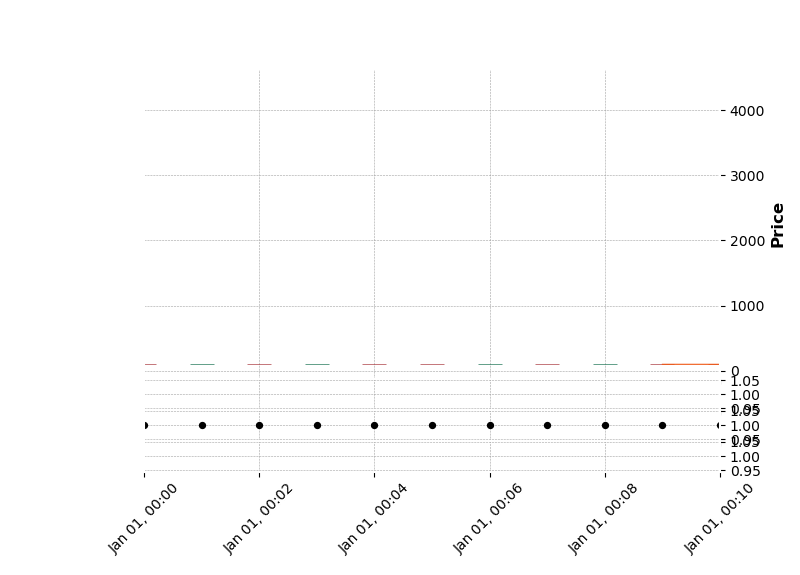

In [20]:
characterize_ohlc(marked_ohlc['crash'][0])

#### Now Using EM

ValueError: zero-size array to reduction operation maximum which has no identity

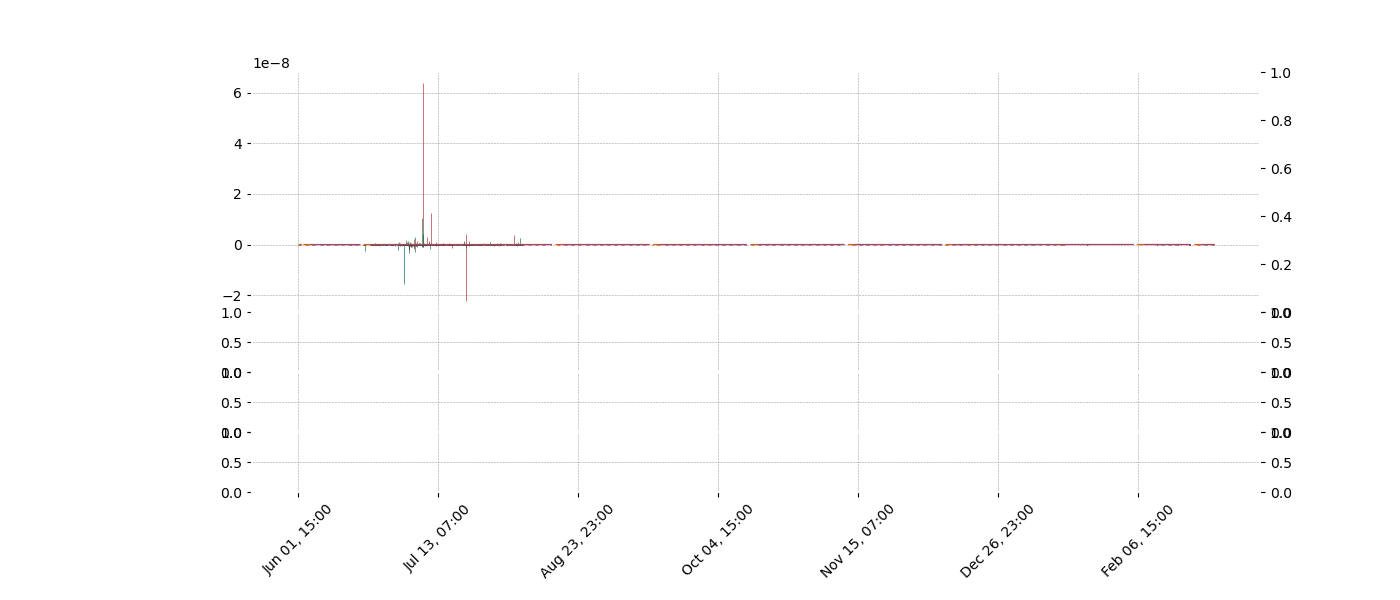

In [21]:
agg_dict = {'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'trades': 'sum'}
bdc_hours = bdc_ohlc.data.resample('h').agg(agg_dict)
bdc_stats = bsc_analysis.OHLCStats(bdc_hours)
loglike, weights = simple_estimate_weights(bdc_hours, '2021-08-01', 2000, 0., em_model)
panels = [
    mpf.make_addplot(weights['P(from moon)'  ], type='scatter', color='g', markersize=1, panel=1),
    mpf.make_addplot(weights['P(from stable)'], type='scatter', color='k', markersize=1, panel=2),
    mpf.make_addplot(weights['P(from crash)' ], type='scatter', color='r', markersize=1, panel=3),
]
mpf.plot(bdc_hours, type='candle', style='charles', figsize=(14,6), mav=[10,20,60], warn_too_much_data=100000, addplot=panels, panel_ratios=(4,1,1,1))